# StayEstimate - Predictive Model
Prepare the features, setup the model, and visualize the results

## Initialize Paths

In [1]:
#Input Path
Input='Input'
#Output Path
Output='Output'
#Transitional Path
Trans='Transitional'

## Import Libraries

In [2]:
from os.path import join
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import numpy as np
from sklearn import cross_validation
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from subprocess import check_call
from ipywidgets import interact
from IPython.display import Image
%matplotlib inline
plt.rcParams.update({'font.size': 14})

## Pre-Processing

In [3]:
df=DataFrame.from_csv(join(Trans,'df_5yr_cleaned.csv'))

In [4]:
df.columns

Index([u'Gender', u'Age', u'Race', u'Severity', u'Mortality', u'DRG',
       u'MedicalSurgical', u'Admission', u'AdmitDay', u'Disposition',
       u'DischDay', u'Total_Charges', u'Year', u'Stay_Length'],
      dtype='object')

In [5]:
#10 Different Diagnosis
dia10=['ACUTE CVD','APPENDICITIS','ABDOMINAL HERNIA','ARM FRACTURE','COLON CANCER','LEUKEMIAS',
        'HEART VALVE DISORDER','ANEURYSM','INTRACRANIAL INJURY','INTESTINAL OBSTRUCTION']

In [6]:
df10=df.ix[dia10]
print "Number of records:%d"%len(df10)

Number of records:656362


In [7]:
#remove Expired records
df10=df10[df10['Disposition']!='Expired']
print "Number of records(W/O Expired):%d"%len(df10)
#remove Newborn & Trauma records
df10=df10[(df10['Admission']!='Newborn')&(df10['Admission']!='Trauma')]
print "Number of records(W/O Newborn and Trauma):%d"%len(df10)

Number of records(W/O Expired):624085
Number of records(W/O Newborn and Trauma):621181


## Feature Preparation

### Ordinal Features

In [8]:
# Ordinal Columns
df_ordinal=df10[['Age','Severity', 'Mortality']]

# Key values for Ordinal 
ord_keys={ '0 to 17':0, '18 to 29':1,'30 to 49':2,'50 to 69':3,'70 or Older':4,
 'Minor':0, 'Moderate':1, 'Major':2, 'Extreme':3}

# Map the ordinal to integer
df_ordinal=df_ordinal.applymap(lambda x:ord_keys[x])

### Binary Features

In [9]:
# Binary Columns
df_binary=df10[['Gender','MedicalSurgical']]

# Key values for binary 
bin_keys={ 'M':0,'F':1,
          'Medical':0, 'Surgical':1}

# Map the ordinal to integer
df_binary=df_binary.applymap(lambda x:bin_keys[x])

### Dummy Features

In [10]:
# Dummy Columns
df_dummy=DataFrame(index=df10.index)

# Race
for cat in ['White','Black/African American']:
    df_dummy['Race_'+cat[:5]]=(df10['Race']==cat)*1

# Admission Type
for cat in ['Emergency', 'Elective']:
    df_dummy['Admit_'+cat]=(df10['Admission']==cat)*1

### Outcome squred-root transformation

### Before

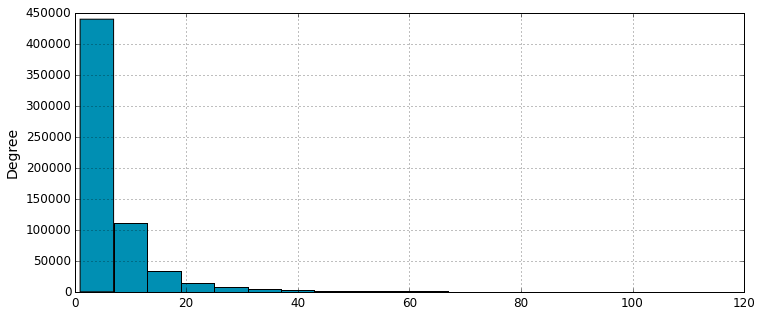

In [11]:
# before cut-off and transformation
df10['Stay_Length'].plot(figsize=(12,5),fontsize=12,kind="hist",bins=20,color='#008fb3');plt.xlim(0, 120);

In [12]:
#squared-root transformation of length of stay to shrink the long tail of histogram
df10['Stay_Length'][df10['Stay_Length']>60]=60
df_outcome=df10['Stay_Length']**.5

### After

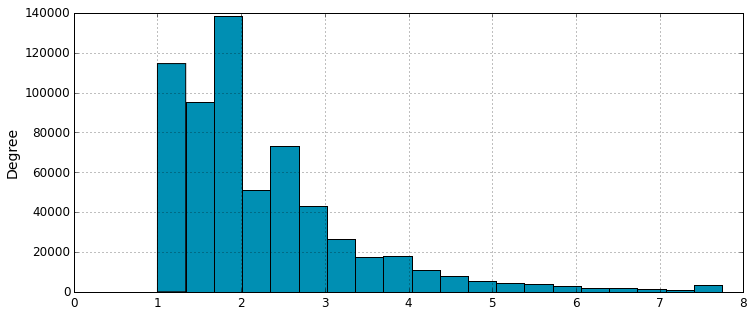

In [13]:
# After cut-off and transformation
df_outcome.plot(figsize=(12,5),fontsize=12,kind="hist",bins=20,color='#008fb3')

In [14]:
#put all features together and then the outcome at the last column
Xy=pd.concat([df_ordinal,df_binary,df_dummy,df_outcome],axis=1)
Xy.head()

,Age,Severity,Mortality,Gender,MedicalSurgical,Race_White,Race_Black,Admit_Emergency,Admit_Elective,Stay_Length
CCS Diagnosis Description,,,,,,,,,,
ACUTE CVD,4,1,1,0,0,0,0,1,0,2.645751
ACUTE CVD,3,1,0,0,1,1,0,0,1,1.000000
ACUTE CVD,4,3,3,0,1,1,0,0,0,3.741657
ACUTE CVD,4,0,1,0,1,1,0,0,1,2.000000
ACUTE CVD,3,2,1,0,1,1,0,0,0,1.732051


## Regression

### Define RandForest Regressor PipeLine

In [15]:
#Random Forest Regressor
def RandForest(Xy,n_estimators=100,max_depth=5):
    ## Train80-Test20
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(Xy.iloc[:,:-1],
                                                                         Xy.iloc[:,-1].values,test_size=0.2,
                                                                         random_state=0)
    ## Random Forest
    rf = RandomForestRegressor(n_estimators=n_estimators,max_depth=max_depth)
    rf.fit(X_train,y_train)
    result=[list(Xy.index.unique())[0],
            rf.score(X_train,y_train),
            rf.score(X_test,y_test),
            len(Xy),
            int(Xy.iloc[:,-1].median()**2),rf]
    return result

### Run the model

In [16]:
result=[]
for dia in Xy.index.unique():
    result.append(RandForest(Xy.ix[dia],n_estimators=20,max_depth=7))
df_r=DataFrame(result)
df_r.columns=['Diagnosis','Train_Score','Test_Score','# of Reccords','Median Stay_Length','Model']
df_r

,Diagnosis,Train_Score,Test_Score,# of Reccords,Median Stay_Length,Model
0,ACUTE CVD,0.439794,0.424323,146761,5,"(DecisionTreeRegressor(criterion='mse', max_de..."
1,APPENDICITIS,0.423451,0.429705,98904,2,"(DecisionTreeRegressor(criterion='mse', max_de..."
2,ABDOMINAL HERNIA,0.448290,0.432939,64791,2,"(DecisionTreeRegressor(criterion='mse', max_de..."
3,ARM FRACTURE,0.445122,0.425935,45759,2,"(DecisionTreeRegressor(criterion='mse', max_de..."
4,COLON CANCER,0.497713,0.474335,29129,7,"(DecisionTreeRegressor(criterion='mse', max_de..."
5,LEUKEMIAS,0.468337,0.447743,12646,11,"(DecisionTreeRegressor(criterion='mse', max_de..."
6,HEART VALVE DISORDER,0.459747,0.441814,44851,7,"(DecisionTreeRegressor(criterion='mse', max_de..."
7,ANEURYSM,0.574266,0.553846,24416,4,"(DecisionTreeRegressor(criterion='mse', max_de..."
8,INTRACRANIAL INJURY,0.617404,0.608489,57782,2,"(DecisionTreeRegressor(criterion='mse', max_de..."
9,INTESTINAL OBSTRUCTION,0.480901,0.489553,96142,4,"(DecisionTreeRegressor(criterion='mse', max_de..."


### Actual vs. Predictied of Length of Stay

<function __main__.plt_err>

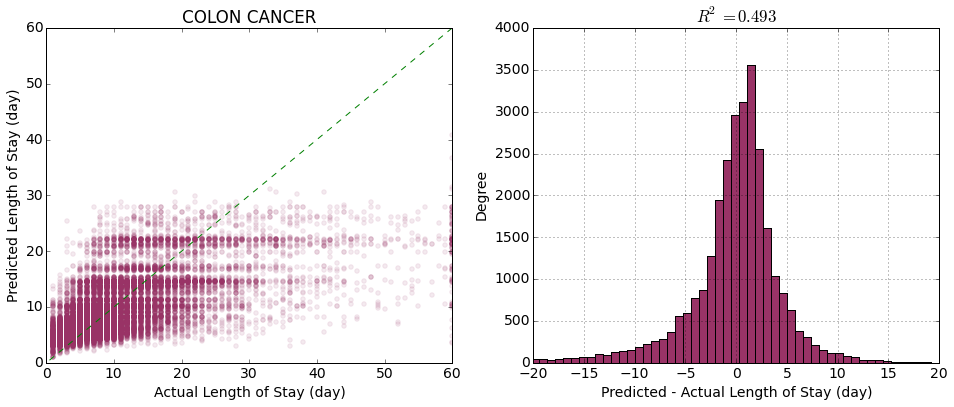

In [31]:
def plt_err(i):
    #recall the model
    rf=df_r.iloc[i,5]
    y_pred=rf.predict(Xy.ix[dia10[i],:-1])
    #Transform back the lengh of stay values
    dplot=Xy.ix[dia10[i],-1:]**2
    dplot['predicted']=y_pred**2
    dplot['Yer']=dplot.predicted-dplot.Stay_Length
    # calculate r-sqaured
    r2=rf.score(Xy.ix[dia10[i],:-1],Xy.ix[dia10[i],-1])

    #plot The actual lengh of stay vs. predicted  and the histogram of error
    f, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6))
    ax1.set_title(dia10[i])
    ax1.scatter(dplot.iloc[:,0],dplot.iloc[:,1],alpha=0.1,color='#993366')
    ax1.plot((60,0,),(60,0),'--g')
    ax1.set_xlim(0, 60);ax1.set_ylim(0, 60);
    ax1.set_xlabel('Actual Length of Stay (day)')
    ax1.set_ylabel('Predicted Length of Stay (day)')
    dplot['Yer'].plot(kind='hist',bins=100,xlim=(-20,20),color='#993366')
    ax2.set_xlabel('Predicted - Actual Length of Stay (day)')
    ax2.set_title('${R}^2=%.3f$'%r2)
interact(plt_err,i=(0,len(df_r)-1))

### Feature Importance

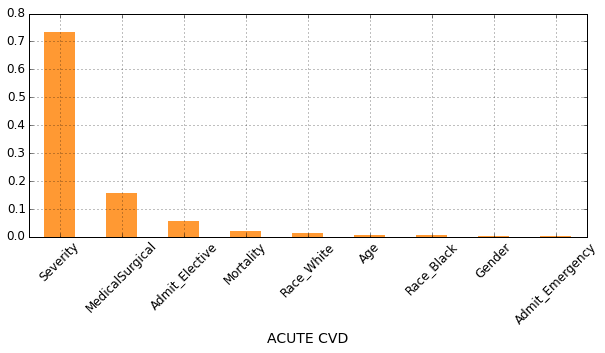

In [18]:
### Visualize Feature Importance in the Forest
def make_bars(i):
    Dia=df_r.iloc[i-1,0]
    rf=df_r.iloc[i-1,5]
    temp=DataFrame(sorted(zip(rf.feature_importances_,Xy.columns[:-1]),reverse=True))
    temp=temp.rename(columns={1:Dia})
    temp.index=temp[Dia]
    temp.plot(kind='bar',fontsize=12,figsize=(10, 4),
                      color=['#ff9933'],#color=['lightskyblue'],
                      edgecolor = "none",rot =45,legend=False)
#Interactive Visualization of Feature Importance
interact(make_bars,i=(1,len(df_r)))

### Forest Visualization

ACUTE CVD


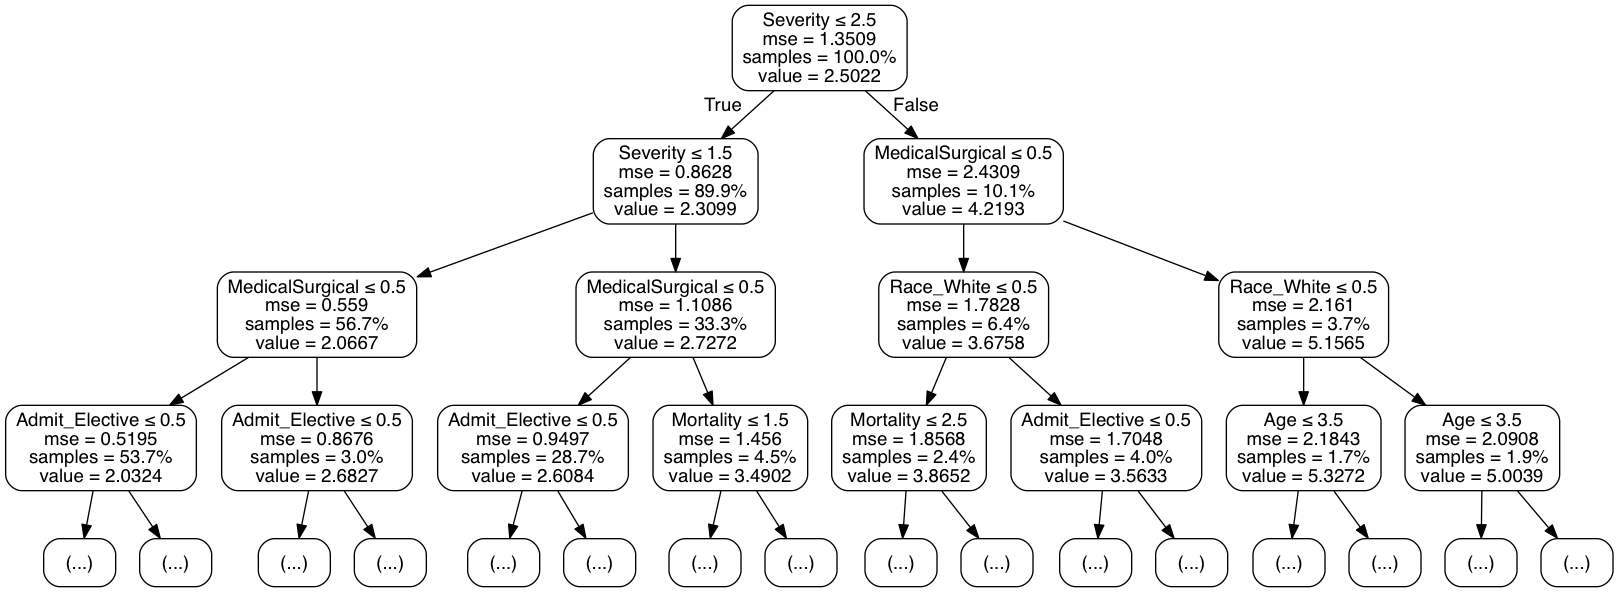

In [27]:
#### Visualize the Forest for ACUTE CVD
d=0 #ACUTE CVD
rf=df_r.iloc[d,5] 
#Create png of trees in forest
i_tree = 0
for tree_in_forest in rf.estimators_:
    tree.export_graphviz(tree_in_forest, out_file = 'temp', max_depth=3,
                         feature_names=Xy.columns[:-1],proportion=True,
                         rounded=True, special_characters=True)
    out_file=join(Output,'tree_' + str(i_tree) + '.png')
    check_call(['dot','-Tpng','temp','-o',out_file])
    i_tree += 1

#Interactive Visualization of Trees
def make_plot(trees):
    print dia10[d]
    out_file=join(Output,'tree_' + str(trees-1) + '.png')
    return Image(out_file, width=1000)
interact(make_plot,trees=(1,len(rf.estimators_)))